In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('../data/filtered_reviews_in_Phonex.csv')
data.head(3)

,Unnamed: 0,review_id,user_id,business_id,stars,business_name,city,state,categories
0,1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,Angry Crab Shack,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr..."
1,2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,Angry Crab Shack,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr..."
2,3,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,Angry Crab Shack,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr..."


### Construct Rating Matrix

In [3]:
def construct_rating_matrix(data, user, busi, rating):
    '''
    construct rating matrix from data
    the columns of which represent business_id
    the rows of which represent user_id
    the values of whose elements represent the according ratings
    '''
    user_id = data[user].unique().tolist()
    busi_id = data[busi].unique().tolist()
    sparse_matrix = np.zeros(shape=(len(user_id), len(busi_id)))
    
    ranking_df = data[[user, busi, rating]].groupby([user, busi]).count()
    ranking_df = ranking_df.reset_index()

    for i in range(len(ranking_df)):
        row_index, column_index = user_id.index(ranking_df.iloc[i, :].user_id), busi_id.index(ranking_df.iloc[i, :].business_id)
        element = ranking_df.iloc[i, :].stars
        sparse_matrix[row_index, column_index] = element
        
    # calculate sparstiy of the matrix
    sparsity = np.count_nonzero(sparse_matrix)/ (sparse_matrix.shape[0] * sparse_matrix.shape[1])
    sparsity *= 100
    
    print (f'{len(user_id)} users')
    print (f'{len(busi_id)} business')
    print (f'Sparsity: {round(sparsity,4)}%')
    return sparse_matrix

In [4]:
rating_matrix = construct_rating_matrix(data, 'user_id', 'business_id', 'stars')

7284 users
2419 business
Sparsity: 0.8937%


### Construct CF model using SGD, with bias correction

In [5]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [6]:
train, test = train_test_split(ratings=rating_matrix)

In [7]:
def get_mse(pred, actual):
        # Ignore nonzero terms.
        pred = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        
        return mean_squared_error(pred, actual)

In [8]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user * item
        
        Params
        ======
        ratings : (ndarray)
            User * Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix factorization model
            
        learning : (str)
            Method of optimization. Options include 'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
            self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """One of the two ALS steps. Solve for the latent vectors specified by type. """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
       
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """  Train model for n_iter iterations. Can be called multiple times for further training."""
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
                
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')

            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate *  (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate *  (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate *  (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
            
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
            
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

### Computation

In [9]:
start_time = time.time()

MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 5, 10, 25, 50]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

end_time = time.time()
print(f'running time: {end_time-start_time}')

Iteration: 1
Train mse: 0.11697567882578336
Test mse: 0.09858311946360124
Iteration: 5
Train mse: 0.11310675597146336
Test mse: 0.09809305676566094
Iteration: 10
Train mse: 0.11069754254936283
Test mse: 0.09787087707146236
Iteration: 25
	current iteration: 10
Train mse: 0.10750347616787943
Test mse: 0.09784394565261414
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.1051894506455994
Test mse: 0.09830838433880142
running time: 270.62271904945374


### Visulazation

In [10]:
def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, label='Test', linewidth=5)
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

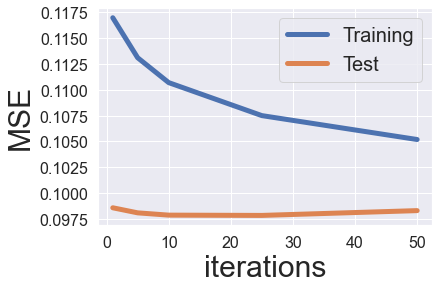

In [11]:
plot_learning_curve(iter_array, MF_SGD)

### Optimize SGD model parameters

In [ ]:
iter_array =  [1, 5, 10, 25, 50]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print ('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print ('New optimal hyperparameters')
        print (pd.Series(best_params))

Rate: 1e-05
New optimal hyperparameters
learning_rate                                             1e-05
n_iter                                                       50
train_mse                                              0.117736
test_mse                                               0.098679
model            <__main__.ExplicitMF object at 0x7fb59ec771d0>
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                            0.0001
n_iter                                                       50
train_mse                                              0.113121
test_mse                                              0.0981137
model            <__main__.ExplicitMF object at 0x7fb59ec77210>
dtype: object
Rate: 0.001


### To be done:
-  1. Modify the train_test_split part; split based on time series, rather than users.
-  2. Tune the parameters (training may need lots of time considering the low learning rate)